# 日経平均株価 15分足

### 一つ上のディレクトリをパスに追加

In [89]:
import sys

path_up = ".."
if not path_up in sys.path:
    sys.path.append(path_up)

### ライブラリをここで一括インポート

In [90]:
import datetime

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import mplfinance as mpf
import numpy as np
import pandas as pd
import yfinance as yf

from funcs.commons import (
    get_name_15min_chart,
    get_name_15min_chart_now,
    get_name_15min_chart_usd,
)

## yfinance による株価データの取得

In [91]:
code = "N225"
symbol = f"^{code}"
ticker1 = yf.Ticker(symbol)
df = ticker1.history(period="1d", interval="15m")
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2025-10-29 09:00:00+09:00,50453.640625,50772.789062,50365.621094,50770.968750,0,0.0,0.0
2025-10-29 09:15:00+09:00,50768.269531,50843.570312,50710.898438,50830.628906,0,0.0,0.0
2025-10-29 09:30:00+09:00,50829.558594,50910.839844,50816.300781,50886.960938,0,0.0,0.0
2025-10-29 09:45:00+09:00,50889.949219,50896.531250,50748.988281,50852.230469,0,0.0,0.0
2025-10-29 10:00:00+09:00,50852.011719,50954.910156,50811.648438,50947.140625,0,0.0,0.0
2025-10-29 10:15:00+09:00,50942.691406,51048.140625,50924.539062,51004.281250,0,0.0,0.0
2025-10-29 10:30:00+09:00,51009.488281,51233.500000,51009.488281,51175.949219,0,0.0,0.0


## 前日終値の取得

In [92]:
# 過去一週間のデータを取得
td = datetime.timedelta(days=7)
dt_first = df.index[0]
dt_prev = dt_first - td
df_last = ticker1.history(interval="1d", start=str(dt_prev.date()))
print(df_last["Close"])
n = len(df_last)
lastclose = df_last[n - 2 : n - 1]["Close"].iloc[0]
# lastclose = 44902.27 # 9/16 終値
# 確認のため出力
df_last[n - 2 : n - 1]["Close"]

Date
2025-10-22 00:00:00+09:00    49307.789062
2025-10-23 00:00:00+09:00    48641.609375
2025-10-24 00:00:00+09:00    49299.648438
2025-10-27 00:00:00+09:00    50512.320312
2025-10-28 00:00:00+09:00    50219.179688
2025-10-29 00:00:00+09:00    51175.949219
Name: Close, dtype: float64


Date
2025-10-28 00:00:00+09:00    50219.179688
Name: Close, dtype: float64

### 当日始値 - 前日終値

In [93]:
delta_open = df.head(1)["Open"].iloc[0] - lastclose
print(f"{delta_open:+.2f}")

+234.46


## ローソク足チャート（小さいサイズ）

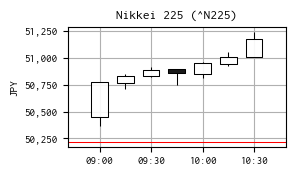

In [94]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()
plt.rcParams["font.size"] = 8

fig, ax = plt.subplots(figsize=(3, 1.8))

ax.axhline(y=lastclose, color="red", linewidth=0.75)
mpf.plot(
    df,
    type="candle",
    style="default",
    datetime_format="%H:%M",
    xrotation=0,
    update_width_config=dict(candle_linewidth=0.75),
    ax=ax,
)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax.set_ylabel("JPY")
ax.grid()

if "shortName" in ticker1.info:
    ax.set_title(f"{ticker1.info['shortName']} ({symbol})")
elif "longName" in ticker1.info:
    ax.set_title(f"{ticker1.info['longName']} ({symbol})")
else:
    ax.set_title(f"{symbol}")

plt.tight_layout()
plt.savefig(get_name_15min_chart(code, dt_first))
plt.show()

## ドル円レートで換算

In [95]:
code2 = "USDJPY=X"
symbol2 = code2
ticker2 = yf.Ticker(symbol2)

### 過去２日分のドル円レートの過去データを取得

In [96]:
# 15分足で過去 2 日分のデータを取得
df_exchange = ticker2.history(period="2d", interval="15m")
df_exchange.index = df_exchange.index.tz_convert("Asia/Tokyo")
df_exchange

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2025-10-28 09:00:00+09:00,152.692001,152.735992,152.544998,152.556000,0,0.0,0.0
2025-10-28 09:15:00+09:00,152.556000,152.606003,152.498993,152.509995,0,0.0,0.0
2025-10-28 09:30:00+09:00,152.513000,152.522995,152.393997,152.449005,0,0.0,0.0
2025-10-28 09:45:00+09:00,152.449005,152.559998,152.389008,152.492996,0,0.0,0.0
2025-10-28 10:00:00+09:00,152.488998,152.511993,152.285995,152.302002,0,0.0,0.0
...,...,...,...,...,...,...,...
2025-10-29 09:45:00+09:00,151.806000,151.809006,151.542999,151.634003,0,0.0,0.0
2025-10-29 10:00:00+09:00,151.626999,151.723007,151.542007,151.666000,0,0.0,0.0
2025-10-29 10:15:00+09:00,151.671005,151.794006,151.598007,151.740005,0,0.0,0.0


### 15分足の Close のドル円レートで一括割る

In [97]:
ser_rate = df_exchange.loc[df.index, "Close"]
ser_rate
df2 = pd.DataFrame()
df2["Open"] = df["Open"] / ser_rate
df2["High"] = df["High"] / ser_rate
df2["Low"] = df["Low"] / ser_rate
df2["Close"] = df["Close"] / ser_rate
df2

,Open,High,Low,Close
Datetime,,,,
2025-10-29 09:00:00+09:00,332.526901,334.630326,331.946787,334.618329
2025-10-29 09:15:00+09:00,334.399973,334.895963,334.022081,334.810721
2025-10-29 09:30:00+09:00,334.832343,335.367772,334.745009,335.210473
2025-10-29 09:45:00+09:00,335.610406,335.653813,334.680793,335.361657
2025-10-29 10:00:00+09:00,335.289462,335.967917,335.023330,335.916689
2025-10-29 10:15:00+09:00,335.723537,336.418471,335.603909,336.129428
2025-10-29 10:30:00+09:00,335.829550,337.304368,335.829550,336.925473


### 前日の終値のドル円レートから、前日の終値のドル換算

In [98]:
dt = df_exchange.head(1).index[0]
dt_last_close = pd.to_datetime(f"{str(dt.date())} 15:15:00+09:00")
print(dt_last_close)
last_close_usd = df_exchange.loc[dt_last_close, "Close"]
last_close_usd

2025-10-28 15:15:00+09:00


np.float64(151.97900390625)

## ローソク足チャート（小さいサイズ）/ ドル換算チャート

前日終値（ドル換算） 330.4349837591927


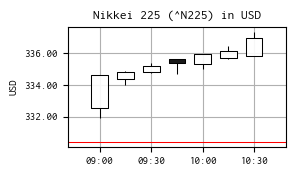

In [99]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()
plt.rcParams["font.size"] = 8

fig, ax = plt.subplots(figsize=(3, 1.8))

ax.axhline(y=lastclose / last_close_usd, color="red", linewidth=0.75)
print("前日終値（ドル換算）", lastclose / last_close_usd)
mpf.plot(
    df2,
    type="candle",
    style="default",
    datetime_format="%H:%M",
    xrotation=0,
    update_width_config=dict(candle_linewidth=0.75),
    ax=ax,
)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.2f}'))
ax.set_ylabel("USD")
ax.grid()

if "shortName" in ticker1.info:
    ax.set_title(f"{ticker1.info['shortName']} ({symbol}) in USD")
elif "longName" in ticker1.info:
    ax.set_title(f"{ticker1.info['longName']} ({symbol}) in USD")
else:
    ax.set_title(f"{symbol}")

plt.tight_layout()
plt.savefig(get_name_15min_chart_usd(code, dt_first))
plt.show()